
# ML Assignment 5 — Iris: Linear Regression, Oversampling & SMOTE
**Author:** Auto-generated solution  
**Dataset:** Iris (via `sklearn.datasets`) — identical to Kaggle version in content structure.

This notebook solves all three tasks:

1. **Baseline:** Train/Val/Test splits and a linear-regression-based classifier (one-vs-rest) to predict species.
2. **Oversampling:** Randomly remove samples from one class in the training set, rebalance via random oversampling, train & compare.
3. **SMOTE:** Repeat (2) but rebalance with a simple SMOTE implementation (no external dependencies).

> Note: Using linear regression for classification is unconventional; we implement a one-vs-rest scheme and pick the argmax of the three regressors.


In [5]:

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)


## Load Iris dataset

In [6]:

iris = load_iris()
X_full = iris['data']
y_full = iris['target']
target_names = iris['target_names']

df = pd.DataFrame(X_full, columns=iris['feature_names'])
df['species_id'] = y_full
df['species'] = [target_names[i] for i in y_full]
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_id,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


## Train / Validation / Test split (stratified)

In [7]:

# 60/20/20 with stratification
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 0.25 * 0.8 = 0.2

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


Shapes:
Train: (90, 4) (90,)
Val  : (30, 4) (30,)
Test : (30, 4) (30,)


## One-vs-Rest Linear Regression classifier utility

In [8]:

def fit_ovr_linear_regression(X, y, scale=True):
    # Train one LinearRegression per class (0,1,2) with binary targets.
    scaler = None
    X_use = X
    if scale:
        scaler = StandardScaler()
        X_use = scaler.fit_transform(X)

    models = []
    classes = np.unique(y)
    for c in classes:
        y_bin = (y == c).astype(float)
        model = LinearRegression()
        model.fit(X_use, y_bin)
        models.append(model)
    return models, scaler

def predict_ovr(models, scaler, X):
    X_use = scaler.transform(X) if scaler is not None else X
    preds = np.column_stack([m.predict(X_use) for m in models])
    return preds.argmax(axis=1), preds

def evaluate_classifier(models, scaler, X, y, split_name=""):
    y_pred, scores = predict_ovr(models, scaler, X)
    acc = accuracy_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    print(f"{split_name} Accuracy: {acc:.4f} | MSE: {mse:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
    print("\nClassification Report:\n", classification_report(y, y_pred, target_names=target_names))
    return acc, mse, y_pred, scores


## Q1: Baseline — Train OVR Linear Regression and evaluate on train/val/test

In [9]:

baseline_models, baseline_scaler = fit_ovr_linear_regression(X_train, y_train, scale=True)
acc_train, mse_train, yhat_train, _ = evaluate_classifier(baseline_models, baseline_scaler, X_train, y_train, "Train")
acc_val,   mse_val,   yhat_val,   _ = evaluate_classifier(baseline_models, baseline_scaler, X_val,   y_val,   "Val")
acc_test,  mse_test,  yhat_test,  _ = evaluate_classifier(baseline_models, baseline_scaler, X_test,  y_test,  "Test")

baseline_results = {
    "split": ["train", "val", "test"],
    "accuracy": [acc_train, acc_val, acc_test],
    "mse": [mse_train, mse_val, mse_test]
}
pd.DataFrame(baseline_results)


Train Accuracy: 0.9000 | MSE: 0.1000
Confusion Matrix:
 [[30  0  0]
 [ 0 24  6]
 [ 0  3 27]]

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        30
  versicolor       0.89      0.80      0.84        30
   virginica       0.82      0.90      0.86        30

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90

Val Accuracy: 0.7333 | MSE: 0.2667
Confusion Matrix:
 [[10  0  0]
 [ 0  6  4]
 [ 0  4  6]]

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.60      0.60      0.60        10
   virginica       0.60      0.60      0.60        10

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30

Test

,split,accuracy,mse
0,train,0.900000,0.100000
1,val,0.733333,0.266667
2,test,0.800000,0.200000


## Helpers: Undersample a chosen class, then rebalance

In [10]:

def undersample_class(X, y, target_class, remove_fraction=0.5, random_state=42):
    # Randomly remove a fraction of samples from target_class in (X,y).
    rng_local = np.random.default_rng(random_state)
    idx_all = np.arange(len(y))
    idx_class = idx_all[y == target_class]
    n_remove = int(len(idx_class) * remove_fraction)
    if n_remove <= 0:
        return X, y, idx_class.size, idx_class.size
    idx_remove = rng_local.choice(idx_class, size=n_remove, replace=False)
    mask_keep = np.ones(len(y), dtype=bool)
    mask_keep[idx_remove] = False
    return X[mask_keep], y[mask_keep], idx_class.size, idx_class.size - n_remove

def random_oversample_to_balance(X, y, random_state=42):
    # Randomly oversample minority classes with replacement to match the max class count.
    rng_local = np.random.default_rng(random_state)
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    X_list, y_list = [], []
    for c in classes:
        Xc = X[y == c]
        yc = y[y == c]
        need = max_count - len(Xc)
        if need > 0:
            idx = rng_local.integers(0, len(Xc), size=need)
            Xc_aug = np.vstack([Xc, Xc[idx]])
            yc_aug = np.concatenate([yc, yc[idx]])
        else:
            Xc_aug, yc_aug = Xc, yc
        X_list.append(Xc_aug)
        y_list.append(yc_aug)
    X_bal = np.vstack(X_list)
    y_bal = np.concatenate(y_list)
    p = rng_local.permutation(len(y_bal))
    return X_bal[p], y_bal[p]


## Q2: For each class, undersample it in TRAIN, then oversample to balance; train & compare

In [11]:

results_q2 = []
for cls in np.unique(y_train):
    Xu, yu, before, after = undersample_class(X_train, y_train, target_class=cls, remove_fraction=0.5, random_state=42)
    X_bal, y_bal = random_oversample_to_balance(Xu, yu, random_state=42)
    models, scaler = fit_ovr_linear_regression(X_bal, y_bal, scale=True)
    acc_tr, _, _, _ = evaluate_classifier(models, scaler, X_bal, y_bal, f"Q2 Class {cls} (reb. Train)")
    acc_v,  _, _, _ = evaluate_classifier(models, scaler, X_val, y_val, f"Q2 Class {cls} (Val)")
    acc_te, _, _, _ = evaluate_classifier(models, scaler, X_test, y_test, f"Q2 Class {cls} (Test)")
    results_q2.append({"class": int(cls), "train_acc": acc_tr, "val_acc": acc_v, "test_acc": acc_te})

df_q2 = pd.DataFrame(results_q2)
df_q2["class_name"] = df_q2["class"].map({i:n for i,n in enumerate(target_names)})
df_q2 = df_q2[["class","class_name","train_acc","val_acc","test_acc"]]
df_q2


Q2 Class 0 (reb. Train) Accuracy: 0.9000 | MSE: 0.1000
Confusion Matrix:
 [[30  0  0]
 [ 0 24  6]
 [ 0  3 27]]

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        30
  versicolor       0.89      0.80      0.84        30
   virginica       0.82      0.90      0.86        30

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90

Q2 Class 0 (Val) Accuracy: 0.7333 | MSE: 0.2667
Confusion Matrix:
 [[10  0  0]
 [ 0  6  4]
 [ 0  4  6]]

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.60      0.60      0.60        10
   virginica       0.60      0.60      0.60        10

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73     

,class,class_name,train_acc,val_acc,test_acc
0,0,setosa,0.900000,0.733333,0.800000
1,1,versicolor,0.822222,0.733333,0.800000
2,2,virginica,0.922222,0.700000,0.766667


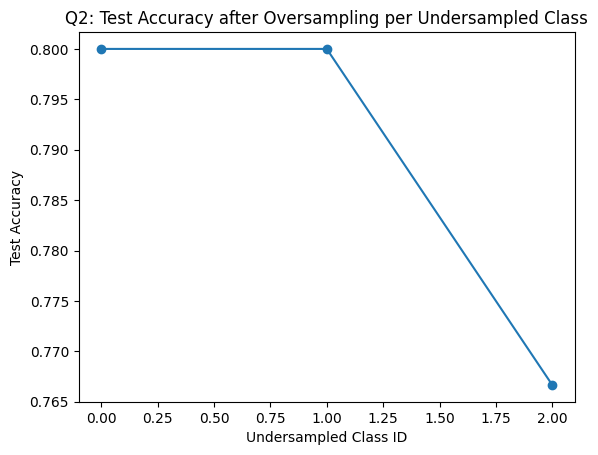

In [12]:

plt.figure()
plt.title("Q2: Test Accuracy after Oversampling per Undersampled Class")
plt.plot(df_q2["class"], df_q2["test_acc"], marker="o")
plt.xlabel("Undersampled Class ID")
plt.ylabel("Test Accuracy")
plt.show()


## Simple SMOTE (no external libraries)

In [13]:

from scipy.spatial import cKDTree

def simple_smote(X, y, k=5, random_state=42):
    # Basic SMOTE for numeric features.
    rng_local = np.random.default_rng(random_state)
    classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()

    X_synth = [X]
    y_synth = [y]

    for c, cnt in zip(classes, counts):
        if cnt == max_count:
            continue
        Xc = X[y == c]
        need = max_count - cnt
        if len(Xc) < 2:
            idx = rng_local.integers(0, len(Xc), size=need)
            X_synth.append(Xc[idx])
            y_synth.append(np.full(need, c))
            continue

        tree = cKDTree(Xc)
        synth = []
        for _ in range(need):
            i = rng_local.integers(0, len(Xc))
            k_eff = min(k+1, len(Xc))
            dists, idxs = tree.query(Xc[i], k=k_eff)
            if k_eff > 1:
                j = rng_local.choice(idxs[1:])
            else:
                j = i
            r = rng_local.random()
            x_new = Xc[i] + r * (Xc[j] - Xc[i])
            synth.append(x_new)
        X_synth.append(np.array(synth))
        y_synth.append(np.full(need, c))

    X_new = np.vstack(X_synth)
    y_new = np.concatenate(y_synth)
    p = rng_local.permutation(len(y_new))
    return X_new[p], y_new[p]


## Q3: For each class, undersample it in TRAIN, then SMOTE to balance; train & compare

In [14]:

results_q3 = []
for cls in np.unique(y_train):
    Xu, yu, before, after = undersample_class(X_train, y_train, target_class=cls, remove_fraction=0.5, random_state=42)
    X_sm, y_sm = simple_smote(Xu, yu, k=5, random_state=42)
    models, scaler = fit_ovr_linear_regression(X_sm, y_sm, scale=True)
    acc_tr, _, _, _ = evaluate_classifier(models, scaler, X_sm, y_sm, f"Q3 Class {cls} (SMOTE Train)")
    acc_v,  _, _, _ = evaluate_classifier(models, scaler, X_val, y_val, f"Q3 Class {cls} (Val)")
    acc_te, _, _, _ = evaluate_classifier(models, scaler, X_test, y_test, f"Q3 Class {cls} (Test)")
    results_q3.append({"class": int(cls), "train_acc": acc_tr, "val_acc": acc_v, "test_acc": acc_te})

df_q3 = pd.DataFrame(results_q3)
df_q3["class_name"] = df_q3["class"].map({i:n for i,n in enumerate(target_names)})
df_q3 = df_q3[["class","class_name","train_acc","val_acc","test_acc"]]
df_q3


Q3 Class 0 (SMOTE Train) Accuracy: 0.9000 | MSE: 0.1000
Confusion Matrix:
 [[30  0  0]
 [ 0 24  6]
 [ 0  3 27]]

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        30
  versicolor       0.89      0.80      0.84        30
   virginica       0.82      0.90      0.86        30

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90

Q3 Class 0 (Val) Accuracy: 0.7333 | MSE: 0.2667
Confusion Matrix:
 [[10  0  0]
 [ 0  6  4]
 [ 0  4  6]]

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.60      0.60      0.60        10
   virginica       0.60      0.60      0.60        10

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73    

,class,class_name,train_acc,val_acc,test_acc
0,0,setosa,0.900000,0.733333,0.800000
1,1,versicolor,0.844444,0.733333,0.800000
2,2,virginica,0.933333,0.766667,0.766667


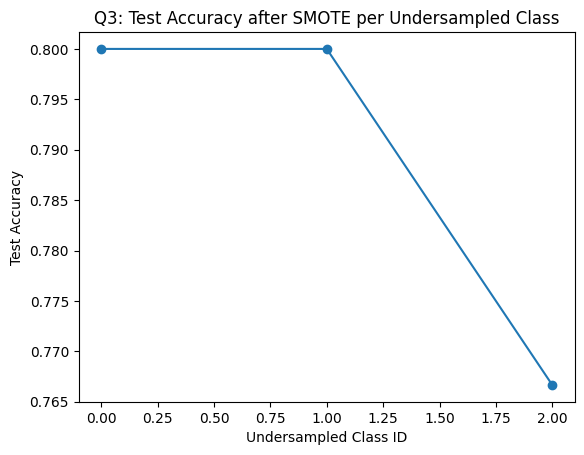

In [15]:

plt.figure()
plt.title("Q3: Test Accuracy after SMOTE per Undersampled Class")
plt.plot(df_q3["class"], df_q3["test_acc"], marker="o")
plt.xlabel("Undersampled Class ID")
plt.ylabel("Test Accuracy")
plt.show()


## Summary & Comparison

In [16]:

summary = pd.DataFrame({
    "setting": ["baseline"],
    "val_acc": [float(np.mean([acc_val]))],
    "test_acc": [float(np.mean([acc_test]))]
})

summary_q2_agg = df_q2.agg({"val_acc":"mean","test_acc":"mean"}).to_frame().T
summary_q2_agg["setting"] = "oversample"
summary_q2_agg = summary_q2_agg[["setting","val_acc","test_acc"]]

summary_q3_agg = df_q3.agg({"val_acc":"mean","test_acc":"mean"}).to_frame().T
summary_q3_agg["setting"] = "smote"
summary_q3_agg = summary_q3_agg[["setting","val_acc","test_acc"]]

final_summary = pd.concat([summary, summary_q2_agg, summary_q3_agg], ignore_index=True)
final_summary


,setting,val_acc,test_acc
0,baseline,0.733333,0.800000
1,oversample,0.722222,0.788889
2,smote,0.744444,0.788889
